In [1]:
import pandas as pd
import numpy as np

# from ark_tokenizer import tokenizeRawTweetText

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score

from nltk.corpus import stopwords
from nltk import word_tokenize
from tqdm import tqdm

from emoji import *

import itertools
import csv
import os

import warnings
warnings.filterwarnings("ignore")

import psycopg2
from psycopg2._psycopg import IntegrityError
import csv

from collections import Counter
import matplotlib.pyplot as plt

np.random.seed(8)

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('max_colwidth',200)
pd.set_option('precision',2)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

%matplotlib inline


['', '/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python35.zip', '/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5', '/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/plat-darwin', '/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/lib-dynload', '/usr/local/lib/python3.5/site-packages', '/usr/local/lib/python3.5/site-packages/IPython/extensions', '/Users/lorenamesa/.ipython']


In [4]:
def create_splits(data, text_field, target_field):
    model_data = data
    n_ids = model_data.index.nunique()
    n_test = int(round(n_ids * 0.3))
    test_ids = pd.Series(model_data.index.unique()).sample(n=n_test, replace=False)

    test = model_data[model_data.index.isin(test_ids)]
    train = model_data[~model_data.index.isin(test_ids)]

    # x_train, x_test, y_train, y_test = train_test_split(model_data[text_field], model_data[target_field], test_size=0.2)

    y_train = train[target_field]
    x_train = train[text_field]
    y_test = test[target_field]
    x_test = test[text_field]

    return x_train, x_test, y_train, y_test, train, test

In [6]:

class Query(object):

    engine_string = 'postgresql+psycopg2://{0}:{1}:{2}:{3}/{4}'

    def __init__(self, db_config, is_read_only=False):
        '''
        Any config info specified in the config (see CONFIG above) will be added as an attribute to the Query class
        when instantiated. Permits reconnection (see execute method implementations below) if necessary.
        '''
        for key in db_config:
            setattr(self, key, db_config[key])
        self.is_read_only = is_read_only

        self.__connect__()

    def __connect__(self):
        self.connection = psycopg2.connect(host=self.url,
                                           user=self.user_name,
                                           port=self.port,
                                           password=self.password,
                                           dbname=self.db_name)
        self.connection.set_session(readonly=self.is_read_only, autocommit=True)
        self.cursor = self.connection.cursor()

#driving_distance module
#note the lack of trailing semi-colon in the query string, as per the Postgres documentation
sql = """
    select permalink, body, subreddit, label from comments
    where subreddit = 'leagueoflegends';
"""

#make connection between python and postgresql
query = Query(db)

# outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(sql)

with open('leageoflegends_data.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    query.cursor.execute(sql)
    resp = query.cursor.fetchall()
    print(resp)
    counter = 1
    for row in resp:
        print('Writing row {}'.format(counter))
        counter += 1
        writer.writerow(row)
        
query.cursor.close()

print("Done Writing")

[('/r/leagueoflegends/comments/7ag7mf/response_to_dont_get_baited_into_using/dpa4mmk/', "Except they have to say said insult to win the game, they aren't just baited, they are threatened. To go back to your exemple, it's like if the shopkeeper had a ~~shotgun pointed at you~~ *rock* and saying that if you don't steal these sunglasses he'll ~~shoot~~ *throw the rock at you.*", 'leagueoflegends', 0), ('/r/leagueoflegends/comments/7ag7mf/response_to_dont_get_baited_into_using/dp9t0y1/', '50 shades of wat', 'leagueoflegends', 0), ('/r/leagueoflegends/comments/7ag7mf/response_to_dont_get_baited_into_using/dp9togj/', 'Scum to say it all is a very poor road to take. Context matters. When it\'s not directed at anyone in the context of preventing your team from auto losing a game, it\'s vastly different from directing it at another human being. \n\nAnd the big example in which someone was unbanned was for the phrase "neck yourself."', 'leagueoflegends', 0), ('/r/leagueoflegends/comments/7ag7mf/

In [3]:
import string

def tokenize(comment, exclude_stop_words=False, exclude_punctuation=False):
    comment = comment.lower()
    words = word_tokenize(comment.lower())
    if exclude_stop_words:
        stop = set(stopwords.words('english'))
        words = list(filter(lambda word: word not in stop, words))
    if exclude_punctuation:
        exclude = set(string.punctuation)
        words = list(filter(lambda word: word not in exclude, words))
    return words

def unique_words(comment, exclude_stop_words=False):
    comment = comment.lower()
    unique = set(tokenize(comment))
    if exclude_stop_words:
        stop = set(stopwords.words('english'))
        unique = list(filter(lambda word: word not in stop, unique))
    return unique 

In [4]:
def lexical_diversity(text): 
    return len(tokenize(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

In [8]:
# Analysis on political comments
df = pd.read_csv('politics_comments_before_12_15_17_labeled.csv', names=['permalink', 'body', 'subreddit', 'label'])
# print(df.columns)
df.reset_index(drop=True)
df.index.rename('id', inplace=True)
# df.index = np.arange(1, len(df))
# df.set_index('permalink', inplace=True)
df['num_words'] = df.apply(lambda row: len(tokenize(row['body'])), axis=1)
df['num_words_minus_stop'] = df.apply(lambda row: len(tokenize(row['body'], exclude_stop_words=True)), axis=1)
df['num_unique_words'] = df.apply(lambda row: len(unique_words(row['body'])), axis=1)
df['num_unique_words_minus_stop'] = df.apply(lambda row: len(unique_words(row['body'], exclude_stop_words=True)), axis=1)
# print(df['num_words'].min())

# print(df.iloc[0])

max_num_words = df['num_words'].max()
avg_num_words = df['num_words'].mean()

max_num_minus_stop_words = df['num_words_minus_stop'].max()
avg_num_minus_stop_words = df['num_words_minus_stop'].mean()

aggressive_comments = df[df['label'] == '1']
not_aggressive_comments = df[df['label'] == '0']

labeled_df = df[(df['label'] == '1') | (df['label'] == '0')]

# print(aggressive_comments.head())
max_agg_num_minus_stop_words = aggressive_comments['num_words_minus_stop'].max()
avg_not_agg_num_minus_stop_words_class_0 = not_aggressive_comments['num_words_minus_stop'].mean()

print('The avg number of words per comment is {} vs avg num of words minus stop words {}.'.format(
avg_num_words, avg_num_minus_stop_words))

print('The avg number of words minus stop words per agg comment is {} vs avg number of words minus stop words per non agg comment {}.'.format(
max_agg_num_minus_stop_words, avg_not_agg_num_minus_stop_words_class_0))

print(aggressive_comments.shape)  # 83
print(not_aggressive_comments.shape)  # 2422

corpus_agg = []
corpus_non_agg = []
aggressive_comments.apply(lambda row: corpus_agg.append(row['body']), axis=1)
not_aggressive_comments.apply(lambda row: corpus_non_agg.append(row['body']), axis=1)
# 3% bullying
# 97% not


agg_lex_diversity = lexical_diversity(' '.join(c for  c in corpus_agg))
non_lex_diversity = lexical_diversity(' '.join(c for  c in corpus_non_agg))

sum_agg_num_words = aggressive_comments['num_words'].sum()
sum_non_agg_num_words = not_aggressive_comments['num_words'].sum()

print(sum_agg_num_words)
print(sum_non_agg_num_words)
# df.to_csv('politics_comments_before_12_15_17.csv')

tokenized_agg_cnt = tokenize(' '.join(c for  c in corpus_agg), exclude_stop_words=True, exclude_punctuation=True)
tokenized_non_agg_cnt = tokenize(' '.join(c for  c in corpus_non_agg), exclude_stop_words=True, exclude_punctuation=True)

agg_cnt = Counter()
for word in tokenized_agg_cnt:
    agg_cnt[word] += 1

non_agg_cnt = Counter()
for word in tokenized_non_agg_cnt:
    non_agg_cnt[word] += 1

print(agg_cnt.most_common())
print("--------------")
print(non_agg_cnt.most_common())

The avg number of words per comment is 33.633891693437356 vs avg num of words minus stop words 19.96225332721432.
The avg number of words minus stop words per agg comment is 62 vs avg number of words minus stop words per non agg comment 19.038891187422426.
(83, 8)
(2417, 8)
1980
77657
[("'s", 20), ('fuck', 19), ('fucking', 18), ("n't", 16), ('...', 11), ('get', 9), ('``', 9), ("''", 9), ('’', 8), ('shit', 8), ('go', 8), ('trump', 7), ('would', 7), ('traitors', 7), ('going', 7), ('better', 6), ('say', 6), ('people', 6), ('right', 6), ('someone', 5), ('oh', 5), ('”', 4), ('“', 4), ('yeah', 4), ('like', 4), ('stupid', 4), ('see', 4), ('care', 4), ('still', 4), ('run', 4), ('honestly', 3), ('supporters', 3), ('bitchy', 3), ("'re", 3), ('let', 3), ('want', 3), ('come', 3), ('much', 3), ('bing', 3), ("'m", 3), ('gop', 3), ('tell', 3), ('far', 3), ('even', 3), ('america', 3), ('way', 3), ('call', 3), ('said', 3), ('nominate', 3), ('job', 3), ('top', 3), ('away', 3), ('comment', 3), ('bullshit

[("'s", 20), ('fuck', 19), ('fucking', 18), ("n't", 16), ('...', 11), ('get', 9), ('``', 9), ("''", 9), ('’', 8), ('shit', 8)]


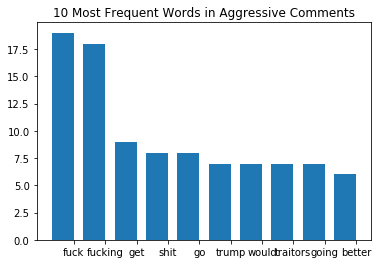

In [11]:
agg_most_common = agg_cnt.most_common()
print(agg_cnt.most_common()[0:10])
agg_words = [k for k, v in agg_most_common[0:16] if k not in ["n't", "'s", "...", "''", "''", '’', '``']]
agg_counts = [v for k, v in agg_most_common[0:16] if k not in ["n't", "'s", "...", "''", "''", '’', '``', "m"]]
indexes = np.arange(len(agg_words))
width = 0.7
plt.bar(indexes, agg_counts, width)
plt.xticks(indexes + width * 0.5, agg_words)
plt.title('10 Most Frequent Words in Aggressive Comments')
plt.show()

[("'s", 839), ("n't", 611), ('trump', 380), ("''", 347), ('``', 306), ('’', 303), ('...', 252), ('would', 245), ('like', 233), ('people', 204)]


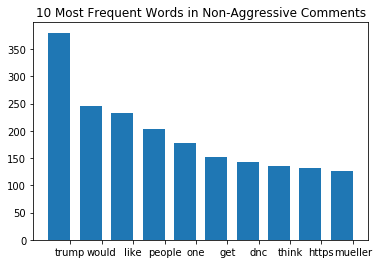

In [15]:
non_agg_most_common = non_agg_cnt.most_common()
print(non_agg_cnt.most_common()[0:10])
non_agg_words = [k for k, v in non_agg_most_common[0:17] if k not in ["n't", "'m", "'s", "...", "''", "''", '’', '``']]
non_agg_counts = [v for k, v in non_agg_most_common[0:17] if k not in ["n't", "'m", "'s", "...", "''", "''", '’', '``']]
indexes = np.arange(len(non_agg_words))
width = 0.7
plt.bar(indexes, non_agg_counts, width)
plt.xticks(indexes + width * 0.5, non_agg_words)
plt.title('10 Most Frequent Words in Non-Aggressive Comments')
plt.show()

In [73]:
print(labeled_df.shape)

(2500, 8)


In [128]:
print(list(labeled_df.index))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [83]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading comments for labeled political reddit data")
print(categories)

dataset = labeled_df

print("%d documents" % len(dataset))
print("%d labels" % len(dataset.label.unique()))
print()

labels = dataset.label
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.body)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

print(km)

Loading comments for labeled political reddit data
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
2500 documents
2 labels

Extracting features from the training dataset using a sparse vectorizer
done in 0.108118s
n_samples: 2500, n_features: 3542

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=False)
done in 0.016s

Homogeneity: 0.001
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: -0.005
Silhouette Coefficient: 0.006

Top terms per cluster:
Cluster 0: trump https say going mueller people did good com president
Cluster 1: just like don time people gop trump need party know
MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=1, random_st

In [ ]:
import numpy as np
np.random.seed(0)

from bokeh.io import curdoc
from bokeh.layouts import widgetbox, row, column
from bokeh.models import ColumnDataSource, Select, Slider
from bokeh.plotting import figure
from bokeh.palettes import Spectral6

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

# class DenseTransformer(TransformerMixin):

#     def transform(self, X, y=None, **fit_params):
#         return X.todense()

#     def fit_transform(self, X, y=None, **fit_params):
#         self.fit(X, y, **fit_params)
#         return self.transform(X)

#     def fit(self, X, y=None, **fit_params):
#         return self
    
# define some helper functions
def clustering(X, algorithm, n_clusters):
    # normalize dataset for easier parameter selection
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
    
#     pipeline = Pipeline([
#      ('vectorizer', vectorizer), 
#      ('to_dense', DenseTransformer())
#     ])
    
#     X = pipeline.fit_transform(X)

    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)

    X = vectorizer.fit_transform(labeled_df['body'].values)
    X = X.todense()
#     X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Generate the new colors:
    if algorithm=='MiniBatchKMeans':
        model = cluster.MiniBatchKMeans(n_clusters=n_clusters)

    elif algorithm=='Birch':
        model = cluster.Birch(n_clusters=n_clusters)

    elif algorithm=='DBSCAN':
        model = cluster.DBSCAN(eps=.2)

    elif algorithm=='AffinityPropagation':
        model = cluster.AffinityPropagation(damping=.9,
                                            preference=-200)

    elif algorithm=='MeanShift':
        model = cluster.MeanShift(bandwidth=bandwidth,
                                  bin_seeding=True)

    elif algorithm=='SpectralClustering':
        model = cluster.SpectralClustering(n_clusters=n_clusters,
                                           eigen_solver='arpack',
                                           affinity="nearest_neighbors")

    elif algorithm=='Ward':
        model = cluster.AgglomerativeClustering(n_clusters=n_clusters,
                                                linkage='ward',
                                                connectivity=connectivity)

    elif algorithm=='AgglomerativeClustering':
        model = cluster.AgglomerativeClustering(linkage="average",
                                                affinity="cityblock",
                                                n_clusters=n_clusters,
                                                connectivity=connectivity)

    model.fit(X)

    if hasattr(model, 'labels_'):
            y_pred = model.labels_.astype(np.int)
    else:
            y_pred = model.predict(X)

    return X, y_pred

# set up initial data
n_samples = 2500
n_clusters = 2
algorithm = 'MiniBatchKMeans'
dataset = 'Subreddit Politics Comments'

X, y = labeled_df['body'], labeled_df['label']
X, y_pred = clustering(X, algorithm, n_clusters)
spectral = np.hstack([Spectral6] * 20)
colors = [spectral[i] for i in y]

# set up plot (styling in theme.yaml)
plot = figure(toolbar_location=None, title=algorithm)
source = ColumnDataSource(data=dict(x=X[:, 0], y=X[:, 1], colors=colors))
plot.circle('x', 'y', fill_color='colors', line_color=None, source=source)

# set up widgets
clustering_algorithms= [
    'MiniBatchKMeans',
    'AffinityPropagation',
    'MeanShift',
    'SpectralClustering',
    'Ward',
    'AgglomerativeClustering',
    'DBSCAN',
    'Birch'
]

datasets_names = [
    'Subreddit Politics Comments'
]

algorithm_select = Select(value='MiniBatchKMeans',
                          title='Select algorithm:',
                          width=200,
                          options=clustering_algorithms)

dataset_select = Select(value='Subreddit Politics Comments',
                        title='Select dataset:',
                        width=200,
                        options=datasets_names)

samples_slider = Slider(title="Number of samples",
                        value=1500.0,
                        start=1000.0,
                        end=3000.0,
                        step=100,
                        width=400)

clusters_slider = Slider(title="Number of clusters",
                         value=2.0,
                         start=2.0,
                         end=10.0,
                         step=1,
                         width=400)

# set up callbacks
def update_algorithm_or_clusters(attrname, old, new):
    global X

    algorithm = algorithm_select.value
    n_clusters = int(clusters_slider.value)

    X, y_pred = clustering(X, algorithm, n_clusters)
    colors = [spectral[i] for i in y_pred]

    source.data = dict(colors=colors, x=X[:, 0], y=X[:, 1])

    plot.title.text = algorithm

def update_samples_or_dataset(attrname, old, new):
    global X, y

    dataset = dataset_select.value
    algorithm = algorithm_select.value
    n_clusters = int(clusters_slider.value)
    n_samples = int(samples_slider.value)

    X, y = get_dataset(dataset, n_samples)
    X, y_pred = clustering(X, algorithm, n_clusters)
    colors = [spectral[i] for i in y_pred]

    source.data = dict(colors=colors, x=X[:, 0], y=X[:, 1])

algorithm_select.on_change('value', update_algorithm_or_clusters)
clusters_slider.on_change('value', update_algorithm_or_clusters)

dataset_select.on_change('value', update_samples_or_dataset)
samples_slider.on_change('value', update_samples_or_dataset)

# set up layout
selects = row(dataset_select, algorithm_select, width=420)
inputs = column(selects, widgetbox(samples_slider, clusters_slider))

# add to document
curdoc().add_root(row(inputs, plot))
curdoc().title = "Clustering"



print('Done')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib as mpl

from sklearn.manifold import MDS

df = pd.read_csv('politics_comments_before_12_15_17_labeled.csv', names=['permalink', 'body', 'subreddit', 'label'])
# print(df.columns)
df.reset_index(drop=True)
df.index.rename('id', inplace=True)
# df.index = np.arange(1, len(df))
# df.set_index('permalink', inplace=True)
df['num_words'] = df.apply(lambda row: len(tokenize(row['body'])), axis=1)
df['num_words_minus_stop'] = df.apply(lambda row: len(tokenize(row['body'], exclude_stop_words=True)), axis=1)
df['num_unique_words'] = df.apply(lambda row: len(unique_words(row['body'])), axis=1)
df['num_unique_words_minus_stop'] = df.apply(lambda row: len(unique_words(row['body'], exclude_stop_words=True)), axis=1)
# print(df['num_words'].min())

# print(df.iloc[0])

max_num_words = df['num_words'].max()
avg_num_words = df['num_words'].mean()

max_num_minus_stop_words = df['num_words_minus_stop'].max()
avg_num_minus_stop_words = df['num_words_minus_stop'].mean()

aggressive_comments = df[df['label'] == '1']
not_aggressive_comments = df[df['label'] == '0']

labeled_df = df[(df['label'] == '1') | (df['label'] == '0')]

print(labeled_df.shape)


In [ ]:
X, y = labeled_df['body'], list(labeled_df['label'])

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=100,
                             min_df=2, stop_words='english',
                             use_idf=True)

X = tfidf_vectorizer.fit_transform(labeled_df['body'].values)
# X = X.todense()
terms = tfidf_vectorizer.get_feature_names()
dist = 1 - cosine_similarity(X)
terms = tfidf_vectorizer.get_feature_names()


MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

clusters = {
    0: 'Not aggressive', 
    1: 'Aggressive', 
}
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, comment=labeled_data['body'])) 
print(df.shape)
#group by cluster
groups = df.groupby('label')
print(groups)

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot
print(plt)
#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [141]:
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file

N = 50000
PLOT_SIZE = 400

# generate datasets.
np.random.seed(0)
noisy_circles = datasets.make_circles(n_samples=N, factor=.5, noise=.04)
noisy_moons = datasets.make_moons(n_samples=N, noise=.05)
centers = [(-2, 3), (2, 3), (-2, -3), (2, -3)]
blobs1 = datasets.make_blobs(centers=centers, n_samples=N, cluster_std=0.4, random_state=8)
blobs2 = datasets.make_blobs(centers=centers, n_samples=N, cluster_std=0.7, random_state=8)

X, y = noisy_circles
print(type(X))
print(type(y))
colors = np.array([x for x in ('#00f', '#0f0', '#f00', '#0ff', '#f0f', '#ff0')])
colors = np.hstack([colors] * 20)

# create clustering algorithms
dbscan   = cluster.DBSCAN(eps=.2)
birch    = cluster.Birch(n_clusters=2)
means    = cluster.MiniBatchKMeans(n_clusters=2)
spectral = cluster.SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity="nearest_neighbors")
affinity = cluster.AffinityPropagation(damping=.9, preference=-200)

# change here, to select clustering algorithm (note: spectral is slow)
algorithm = dbscan  # <- SELECT ALG

plots =[]
for dataset in [labeled_df]:
    X, y = dataset['body'], dataset['label']
    
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)

    X = vectorizer.fit_transform(labeled_df['body'].values)
    X = X.todense()
    print(type(X))
    print(type(y))
    # predict cluster memberships
    algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    p = figure(title=algorithm.__class__.__name__,
               plot_width=PLOT_SIZE, plot_height=PLOT_SIZE)
    X = np.squeeze(np.asarray(X))
    y = np.squeeze(np.asarray(y))
    blobs1 = datasets.make_blobs(centers=centers, n_samples=2500, cluster_std=0.4, random_state=8)
#     blobs2 = datasets.make_blobs(centers=centers, n_samples=N, cluster_std=0.7, random_state=8)
    print(type(y))
    p.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), alpha=0.1,)

    plots.append(p)

# generate layout for the plots
layout = column(row(plots[:2]), row(plots[2:]))

output_file("clustering.html", title="clustering with sklearn")

show(layout)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'pandas.core.series.Series'>


2017-12-16 07:43:48,155 INFO Session output file 'clustering.html' already exists, will be overwritten.
2017-12-16 07:43:48,186 WARNING W-1002 (EMPTY_LAYOUT): Layout has no children: Row(id='1f1dda0f-e0e2-4681-b28b-1661f7fd8db5', ...)
2017-12-16 07:43:48,199 WARNING W-1002 (EMPTY_LAYOUT): Layout has no children: Row(id='0ee1ae67-a8b8-4d38-8710-87767bf2c4ef', ...)
2017-12-16 07:43:48,214 WARNING W-1002 (EMPTY_LAYOUT): Layout has no children: Row(id='a529aa52-56d6-45df-b3b8-ff912cb37d1b', ...)
2017-12-16 07:43:48,230 WARNING W-1002 (EMPTY_LAYOUT): Layout has no children: Row(id='8d5cffed-bdd2-4c78-a994-f184b61db026', ...)


<class 'numpy.ndarray'>


In [9]:
def create_undersampled_splits(data, text_field, target_field):
    model_data = data
    n_ids = model_data.index.nunique()
    n_test = int(round(n_ids * 0.3))
    test_ids = pd.Series(model_data.index.unique()).sample(n=n_test, replace=False)

    test = model_data[model_data.index.isin(test_ids)]
    train = model_data[~model_data.index.isin(test_ids)]
    aggression_min = train.label.value_counts().min()
    aggressive = train[train.label == 'aggressive'].sample(n=aggression_min, replace=False)
    not_aggressive = train[train.label == 'not'].sample(n=aggression_min, replace=False)
    train = pd.concat([aggressive,not_aggressive])
    y_train = train[target_field]
    x_train = train[text_field]
    y_test = test[target_field]
    x_test = test[text_field]

    return x_train, x_test, y_train, y_test, train, test

In [10]:
def create_undersampled_splits(data, text_field, target_field):
    model_data = data
    n_ids = model_data.index.nunique()
    n_test = int(round(n_ids * 0.3))
    test_ids = pd.Series(model_data.index.unique()).sample(n=n_test, replace=False)

    test = model_data[model_data.index.isin(test_ids)]
    train = model_data[~model_data.index.isin(test_ids)]
    aggression_max = train.label.value_counts().max()
    aggressive = train[train.label == 'aggressive'].sample(n=aggression_max, replace=False)
    not_aggressive = train[train.label == 'not'].sample(n=aggression_max, replace=False)
    train = pd.concat([aggressive,not_aggressive])
    y_train = train[target_field]
    x_train = train[text_field]
    y_test = test[target_field]
    x_test = test[text_field]

    return x_train, x_test, y_train, y_test, train, test

In [11]:
def build_model(x_train,y_train, x_test, model):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    return pred

In [15]:
def print_metrics(y_test, y_pred):
    f1_m = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    return f1_m, acc

In [14]:
pipeline_for_multilabel_model = [
        (Pipeline([('vect', CountVectorizer(stop_words='english', min_df=3, ngram_range=(1,2))), 
           ('clf', MultinomialNB())
          ])
        )]

In [ ]:
df = pd.read_csv("../data/label2.train.txt", sep='\001', encoding='utf-8')
# df.drop('TweetID', inplace=True, axis=1)
df.sentiment = df.aggression.str.lower()

df.drop_duplicates(subset='text', inplace=True)

df['is_aggressive'] = np.where(df['aggression'] == 1, 1,0)
df['is_neutral'] = np.where(df['aggression'] == 0, 1,0)

In [ ]:
reddit_comments = df.copy()
x_train, x_test, y_train, y_test, train, test = create_splits(reddit_comments, 'body','label')

with open('results.csv', 'a') as csvfile:
    fieldnames = ['preprocess','model','log_loss','f1_macro', 'accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for experiment in multi_label_models:
        y_pred = build_model(x_train,y_train, x_test, experiment)
        f1_m, acc = print_metrics(y_test, y_pred)
        row_metrics = {'preprocess': 'None:baseline', 'model': repr(experiment.named_steps),
                                              'f1_macro': f1_m, 'accuracy': acc}
        writer.writerow(row_metrics)

In [ ]:
reddit_comments = df.copy()
x_train, x_test, y_train, y_test, train, test = create_splits(reddit_comments, 'body','label')
train = pd.DataFrame(x_train)
train['aggression'] = y_train
train = train[(train.aggression == 'is_aggressive') | (train.aggression == 'is_neutral')]
y_train = train['aggression']
len(y_train)
x_train = train['text']

model.fit(x_train, y_train)
pred = model.predict(x_test)
prob = model.predict_proba(x_test)
x_test = pd.DataFrame(x_test)
x_test['prob_neg'] = prob[:,0]
x_test['prob_pos'] = prob[:,1]
x_test['pred_label'] = 'unknown'


x_test.loc[(x_test['prob_pos'] >= 0.7),'pred_label'] = 'positive'
x_test.loc[(x_test['prob_pos'] < 0.70) & (x_test['prob_neg'] >= 0.70),'pred_label'] = 'negative'
x_test.loc[(x_test['pred_label']== 'unknown'),'pred_label'] = 'neutral'




print 'Metrics for all tweets:'
print classification_report(y_test, x_test['pred_label'])
print accuracy_score(y_test, x_test['pred_label'])
# print log_loss(y_holdout, prob)